## Importando bibliotecas

In [1301]:
# Data analysis and Data wrangling

import pandas as pd

# Data viz

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.offline as pyo

# Time Series Analysis

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Time Series Models

from prophet import Prophet
from pycaret.time_series import *
from sktime.forecasting.model_selection import SlidingWindowSplitter
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

# Numeric

import numpy as np

# Save

import pickle
import plotly.io as pio

## Ajustando parâmetros globais

In [1302]:
colors = ['#013a63', '#366a86', '#649da8', '#9cd2c9', '#ffffe0', '#ffbcaf', '#f4777f', '#cf3759', '#93003a']

sns.set_palette(sns.color_palette(colors))
sns.set_style('darkgrid')
sns.set_context('paper')
plt.rcParams['figure.figsize'] = (14,8)

## Importando datasets e ajustes inciais

In [1303]:
df_1982_1999 = pd.read_csv('../data/raw/Dados Históricos - Ibovespa (1982-1999).csv', converters={'Data': lambda x: pd.to_datetime(x, format='%d.%m.%Y')}, thousands='.')
df_2000_2019 = pd.read_csv('../data/raw/Dados Históricos - Ibovespa (2000-2019).csv', converters={'Data': lambda x: pd.to_datetime(x, format='%d.%m.%Y')}, thousands='.')
df_2020_2024 = pd.read_csv('../data/raw/Dados Históricos - Ibovespa (2020-2024).csv', converters={'Data': lambda x: pd.to_datetime(x, format='%d.%m.%Y')}, thousands='.')

In [1304]:
df_ibov = pd.merge(df_1982_1999, df_2000_2019, how='outer')
df_ibov = pd.merge(df_ibov, df_2020_2024, how='outer')

In [1305]:
df_ibov.dtypes

Data        datetime64[ns]
Último               int64
Abertura             int64
Máxima               int64
Mínima               int64
Vol.                object
Var%                object
dtype: object

In [1306]:
# df_ibov['Data'] = pd.to_datetime(df_ibov['Data'], format="%d.%m.%Y")
df_ibov.set_index('Data', drop=True, inplace=True)
df_ibov.sort_index(axis=0, inplace=True)

In [1307]:
df_ibov

Último  Abertura  Máxima  Mínima     Vol.    Var%
Data                                                         
1982-01-07       0         0       0       0  116,09M   0,00%
1982-01-08       0         0       0       0  329,76M   0,00%
1982-01-11       0         0       0       0  127,52M   0,00%
1982-01-12       0         0       0       0  122,62M   0,00%
1982-01-13       0         0       0       0  106,19M   0,00%
...            ...       ...     ...     ...      ...     ...
2024-06-14  119662    119558  120214  118828    7,85M   0,08%
2024-06-17  119138    119663  119663  118685    7,38M  -0,44%
2024-06-18  119630    119138  120109  118872    8,10M   0,41%
2024-06-19  120261    119630  120383  118960    5,65M   0,53%
2024-06-20  120446    120267  121607  120156    8,66M   0,15%

[10476 rows x 6 columns]

In [1308]:
df_ibov.drop(columns=['Vol.', 'Var%'], inplace=True)

In [1309]:
columns = ['fechamento', 'abertura', 'maxima', 'minima']
df_ibov.columns = columns

In [1310]:
df_ibov

fechamento  abertura  maxima  minima
Data                                            
1982-01-07           0         0       0       0
1982-01-08           0         0       0       0
1982-01-11           0         0       0       0
1982-01-12           0         0       0       0
1982-01-13           0         0       0       0
...                ...       ...     ...     ...
2024-06-14      119662    119558  120214  118828
2024-06-17      119138    119663  119663  118685
2024-06-18      119630    119138  120109  118872
2024-06-19      120261    119630  120383  118960
2024-06-20      120446    120267  121607  120156

[10476 rows x 4 columns]

In [1311]:
for col in df_ibov.columns:
    df_ibov[col] = df_ibov[col].apply(lambda x: float(str(x).replace('.', '')))

In [1312]:
df_ibov.drop(df_ibov[df_ibov['abertura'] == 0].index, inplace=True)

In [1313]:
df_ibov.describe().T

count          mean           std  min       25%      50%  \
fechamento  8038.0  46106.079995  37177.839070  1.0  11490.75  46535.5   
abertura    8038.0  46092.177656  37171.713516  1.0  11496.50  46514.0   
maxima      8038.0  46559.251431  37473.092781  1.0  11626.75  47079.0   
minima      8038.0  45630.437547  36869.918678  1.0  11333.75  45839.0   

                 75%       max  
fechamento  66682.75  134194.0  
abertura    66678.75  134194.0  
maxima      67173.75  134392.0  
minima      66031.00  133832.0

In [1314]:
df_ibov.isna().any()

fechamento    False
abertura      False
maxima        False
minima        False
dtype: bool

## Visualizando distribuição de dados

<Axes: >

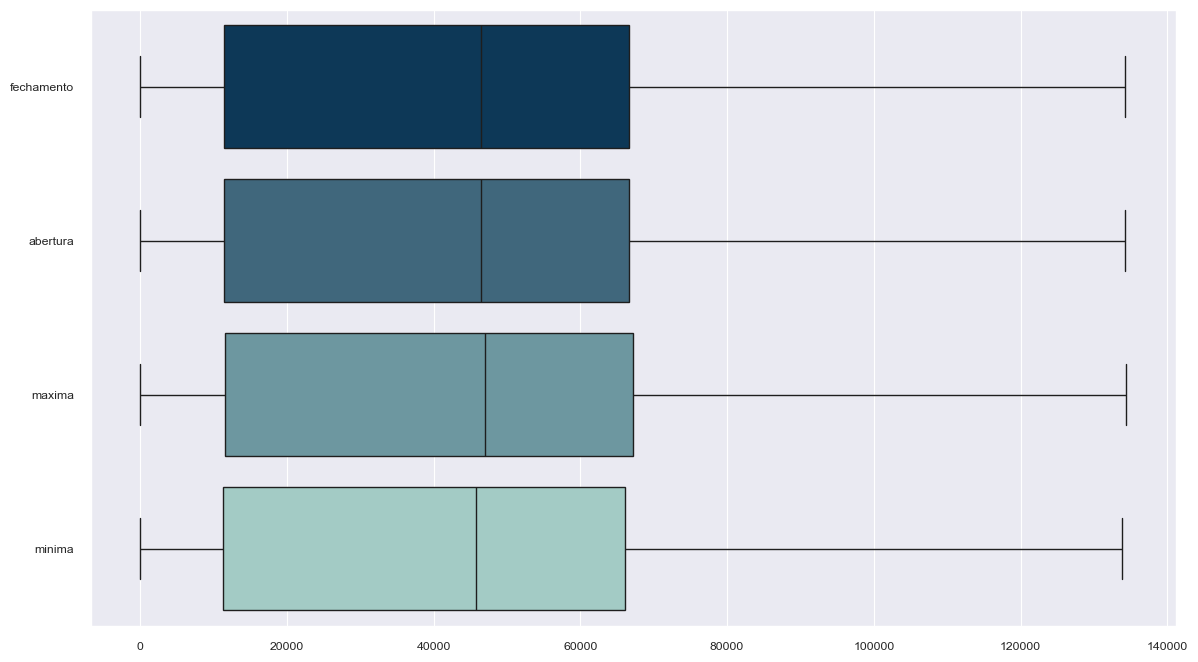

In [1315]:
sns.boxplot(data=df_ibov, orient='h')

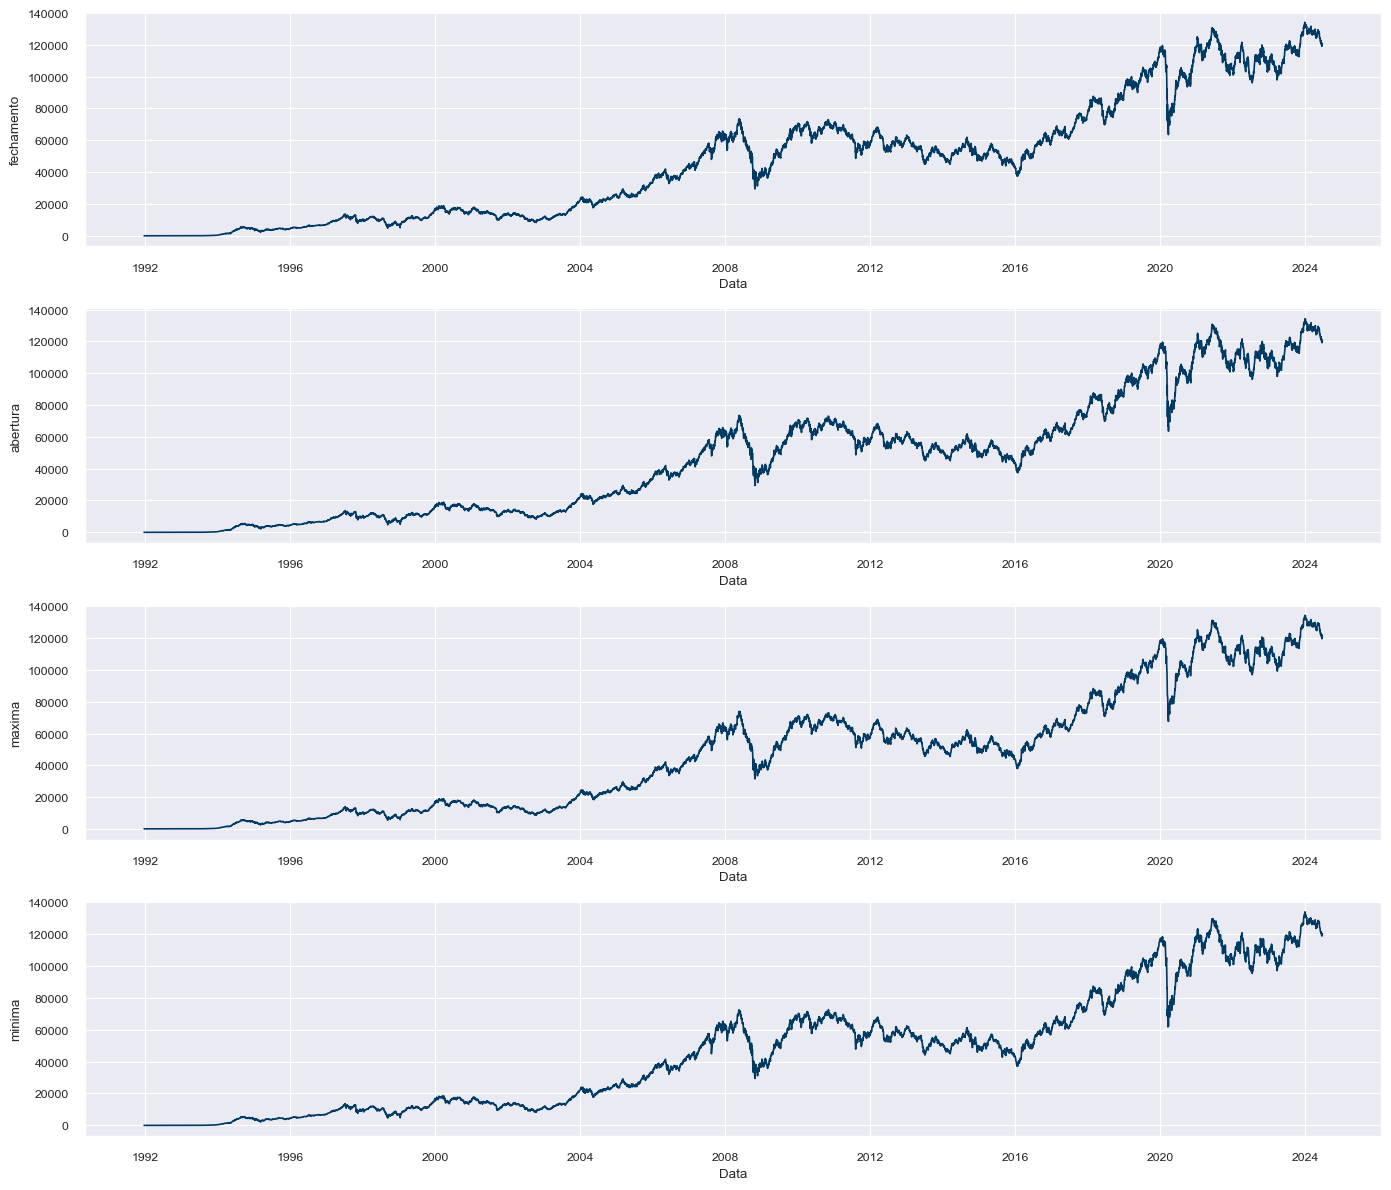

In [1316]:
fig, axs = plt.subplots(4, 1, figsize=(14, 12))

columns = df_ibov.columns

for i, ax in enumerate(axs.flat):
    sns.lineplot(x=df_ibov.index, y=df_ibov[columns[i]], ax=ax)

plt.tight_layout()

with open('/Users/andersonpacheco/Documents/Estudos/01 - Pós Graduacao/Tech Challenge/Ibovespa/ibovespa-prediction/reports/figures/ibov_feature_behaviors.pkl', 'wb') as f:
    pickle.dump(fig, f)

In [1317]:
fig = make_subplots(rows=4, cols=1, shared_xaxes=False, vertical_spacing=0.1)

# Add a line plot for each column in the DataFrame
for i, col in enumerate(columns[:4]):
    fig.add_trace(
        go.Scatter(x=df_ibov.index, y=df_ibov[col], mode='lines', name=col),
        row=i+1, col=1
    )

# Update layout to fit well
fig.update_layout(height=800, width=700, title_text="IBOVESPA - COMPORTAMENTO DAS FEATURES", showlegend=False)
fig.update_xaxes(title_text="data")
# fig.update_yaxes(title_text="Value")

y_axis_titles = df_ibov.columns.tolist()

for i, title in enumerate(y_axis_titles):
    fig.update_yaxes(title_text=title, row=i+1, col=1)

fig.show()

fig.write_html("/Users/andersonpacheco/Documents/Estudos/01 - Pós Graduacao/Tech Challenge/Ibovespa/ibovespa-prediction/reports/figures/ibov_feature_behaviors.html")

# with open('/Users/andersonpacheco/Documents/Estudos/01 - Pós Graduacao/Tech Challenge/Ibovespa/ibovespa-prediction/reports/figures/ibov_feature_behaviors.pkl', 'wb') as f:
    # pickle.dump(fig, f)

<Axes: xlabel='Data', ylabel='fechamento'>

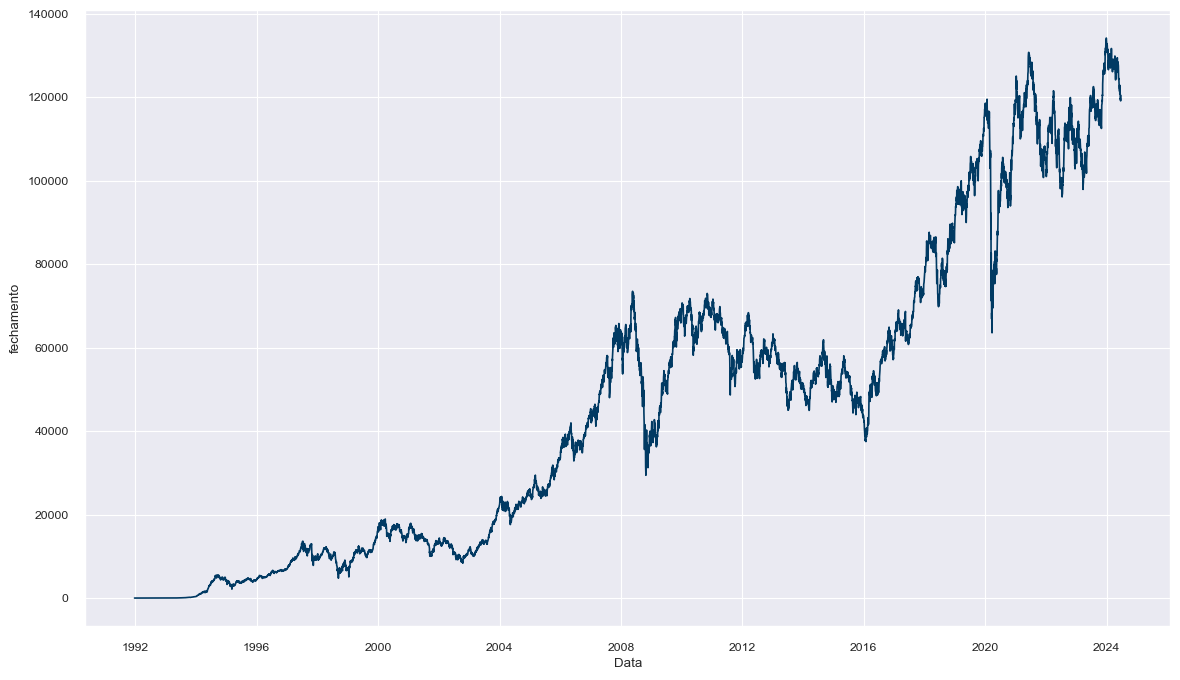

In [1318]:
plt.figure
sns.lineplot(x=df_ibov.index, y=df_ibov['fechamento'])

<Axes: xlabel='Data', ylabel='fechamento'>

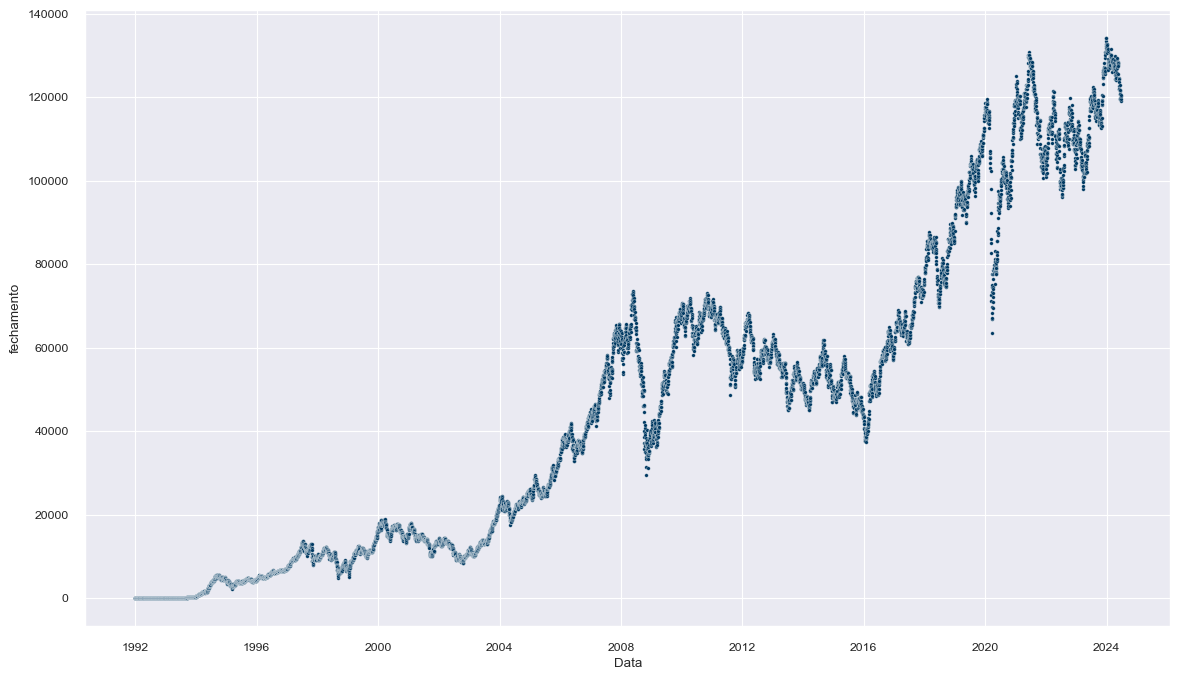

In [1319]:
sns.scatterplot(x=df_ibov.index, y=df_ibov['fechamento'], s=7)

In [1320]:
def filter_by_year(first_year=1992, last_year=2024):
    df_filtered = df_ibov['fechamento'][(df_ibov.index.year >= first_year) & (df_ibov.index.year <= last_year)]
    return df_filtered

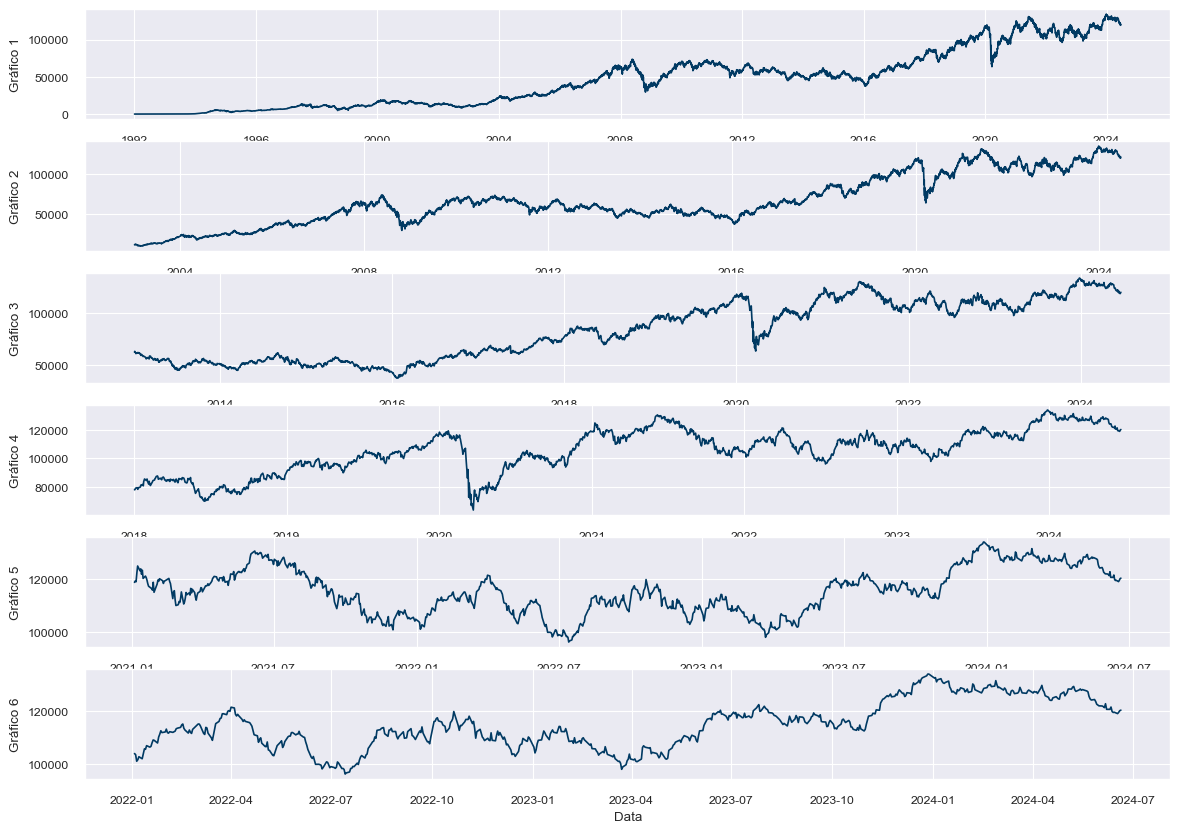

In [1321]:
# visualizando o comportamento dos dados em diferentes timeframes
# todos os dados, 20 anos, 10 anos, 5 anos, 2 anos e 1 ano atrás

years = [1992, 2003, 2013, 2018, 2021, 2022]

fig, axs = plt.subplots(len(years), 1, figsize=(14,10))

for year, ax in zip(years, axs):
    df = filter_by_year(first_year=year)
    sns.lineplot(y=df, x=df.index, ax=ax)
    ax.set_ylabel('Gráfico {}'.format(years.index(year)+1))

In [1322]:
subplot_title = [f'de {year} até 20 de Junho de 2024' for year in years]
fig = make_subplots(rows=len(years), cols=1, shared_xaxes=False, vertical_spacing=0.1, subplot_titles=subplot_title)

for i, year in enumerate(years):
    df = filter_by_year(first_year=year)
    fig.add_trace(
        go.Scatter(x=df.index, y=df, mode='lines', name=str(year)),
        row=i+1, col=1
    )
# Update layout to fit well
    fig.update_yaxes(range= [0, 150000], title_text='fechamento (R$)', row=i+1, col=1)

fig.update_layout(height=1200, width=700, showlegend=False)
fig.update_xaxes(title_text="data")

fig.show()

fig.write_html("/Users/andersonpacheco/Documents/Estudos/01 - Pós Graduacao/Tech Challenge/Ibovespa/ibovespa-prediction/reports/figures/ibov_timeframe_behaviors.html")

## Decompondo dados em sazonalidade, tendência e ruídos

In [1323]:
ibov = filter_by_year(2023)

In [1324]:
print(ibov)

Data
2023-01-02    106376.0
2023-01-03    104166.0
2023-01-04    105334.0
2023-01-05    107641.0
2023-01-06    108964.0
                ...   
2024-06-14    119662.0
2024-06-17    119138.0
2024-06-18    119630.0
2024-06-19    120261.0
2024-06-20    120446.0
Name: fechamento, Length: 366, dtype: float64


In [1325]:
decompose = seasonal_decompose(ibov, period=30)

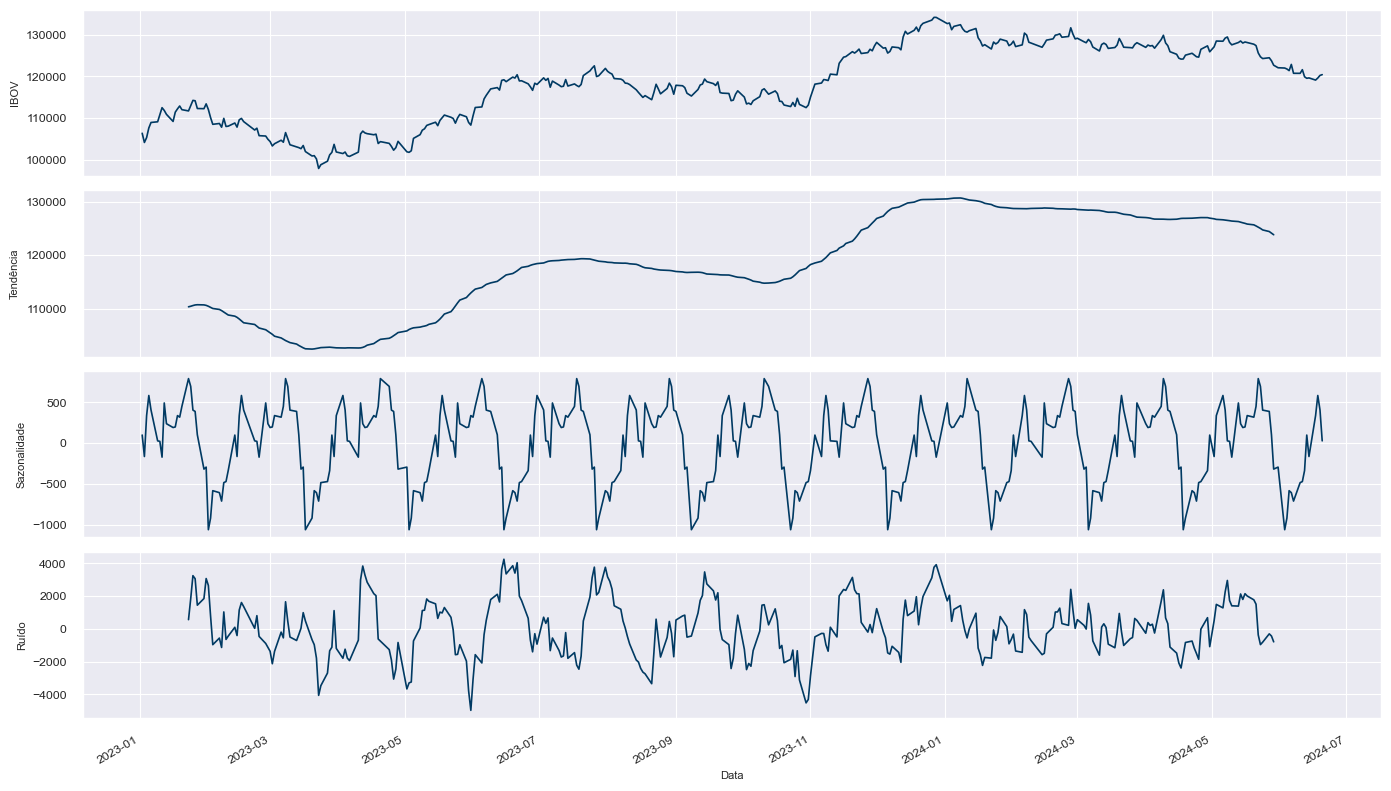

In [1326]:
fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True)

axs[0].set_ylabel('IBOV', fontsize=8)
axs[1].set_ylabel('Tendência', fontsize=8)
axs[2].set_ylabel('Sazonalidade', fontsize=8)
axs[3].set_ylabel('Ruído', fontsize=8)
axs[3].set_xlabel('Data', fontsize=8)

decompose.observed.plot(ax=axs[0])
decompose.trend.plot(ax=axs[1])
decompose.seasonal.plot(ax=axs[2])
decompose.resid.plot(ax=axs[3])

plt.tight_layout()

## Ajustando dias faltantes

In [1327]:
business_days = pd.date_range(start=min(ibov.index), end=max(ibov.index), freq='B')

In [1328]:
ibov = ibov.reindex(business_days)

In [1329]:
ibov.ffill(inplace=True)

## Realizando forecast

### Forecasting

In [1330]:
exp = TSForecastingExperiment()

In [1331]:
exp.setup(data=ibov, coverage=0.9, fold_strategy=SlidingWindowSplitter(fh=np.arange(1,16), window_length=30, step_length=30))

### Visualizando test split e cross validation test

In [1332]:
# fig = exp.plot_model(plot='train_test_split', save='/Users/andersonpacheco/Documents/Estudos/01 - Pós Graduacao/Tech Challenge/Ibovespa/ibovespa-prediction/reports/figures')
fig = exp.plot_model(plot='train_test_split', display_format='plotly-dash', return_fig=True)
fig.show()

In [1333]:
fig.update_layout(title={'text': 'Train Test Split',
                         'x': 0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'
                         },
                    height=400, width=700, legend=dict(orientation='h', yanchor='bottom', y=1.01, xanchor='right', x=0.35), margin=dict(l=20, r=20, t=80, b=40))
fig.update_xaxes()
#fig.show()

pio.write_html(fig, '/Users/andersonpacheco/Documents/Estudos/01 - Pós Graduacao/Tech Challenge/Ibovespa/ibovespa-prediction/reports/figures/ibov_train_test_split.html')

In [1334]:
fig = exp.plot_model(plot='cv', return_fig=True)
fig.show()

In [1335]:
# personalizando e salvando layout de modelo para o streamlit

fig.update_layout(title={'text': 'Train Cross-Validation Splits',
                         'x': 0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'
                         },
                    height=400, width=700, legend=dict(orientation='h', yanchor='bottom', y=1.01, xanchor='right', x=0.35), margin=dict(l=20, r=20, t=80, b=40))
fig.update_xaxes()
# fig.show()

pio.write_html(fig, '/Users/andersonpacheco/Documents/Estudos/01 - Pós Graduacao/Tech Challenge/Ibovespa/ibovespa-prediction/reports/figures/ibov_train_cross_validation.html')

### Comparando modelos

In [1336]:
exp.compare_models(sort='mape')

NaiveForecaster()

### Criando e tunando modelos

In [1337]:
model = exp.create_model('auto_arima')

In [1338]:
tuned_model = exp.tune_model(model)

Fitting 11 folds for each of 1 candidates, totalling 11 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished


## Diagnosticando e visualizando modelos

In [1339]:
exp.plot_model(estimator=tuned_model, plot='diagnostics')

In [1340]:
exp.plot_model(estimator=model, plot='forecast', data_kwargs={'fh': 15})
exp.plot_model(estimator=tuned_model, plot='forecast', data_kwargs={'fh': 15})

In [1341]:
model2 = exp.create_model('ets')

In [1342]:
tuned_model2 = exp.tune_model(model2)

Fitting 11 folds for each of 6 candidates, totalling 66 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  51 out of  66 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:    0.5s finished


In [1343]:
exp.plot_model(estimator=model2, plot='forecast', data_kwargs={'fh': 15})

In [1344]:
exp.models()

Name  \
ID                                                                   
naive                                             Naive Forecaster   
grand_means                                 Grand Means Forecaster   
polytrend                              Polynomial Trend Forecaster   
arima                                                        ARIMA   
auto_arima                                              Auto ARIMA   
exp_smooth                                   Exponential Smoothing   
ets                                                            ETS   
theta                                             Theta Forecaster   
croston                                                    Croston   
bats                                                          BATS   
tbats                                                        TBATS   
prophet                                                    Prophet   
lr_cds_dt               Linear w/ Cond. Deseasonalize & Detrending   
en_cds_dt          Elastic Net w/ Cond. Deseasonalize & Detrending   
ridge_cds_dt             Ridge w/ Cond. Deseasonalize & Detrending   
lasso_cds_dt             Lasso w/ Cond. Deseasonalize & Detrending   
llar_cds_dt      Lasso Least Angular Regressor w/ Cond. Deseaso...   
br_cds_dt        Bayesian Ridge w/ Cond. Deseasonalize & Detren...   
huber_cds_dt             Huber w/ Cond. Deseasonalize & Detrending   
omp_cds_dt       Orthogonal Matching Pursuit w/ Cond. Deseasona...   
knn_cds_dt         K Neighbors w/ Cond. Deseasonalize & Detrending   
dt_cds_dt        Decision Tree w/ Cond. Deseasonalize & Detrending   
rf_cds_dt        Random Forest w/ Cond. Deseasonalize & Detrending   
et_cds_dt          Extra Trees w/ Cond. Deseasonalize & Detrending   
gbr_cds_dt       Gradient Boosting w/ Cond. Deseasonalize & Det...   
ada_cds_dt            AdaBoost w/ Cond. Deseasonalize & Detrending   
xgboost_cds_dt   Extreme Gradient Boosting w/ Cond. Deseasonali...   
lightgbm_cds_dt  Light Gradient Boosting w/ Cond. Deseasonalize...   
catboost_cds_dt  CatBoost Regressor w/ Cond. Deseasonalize & De...   

                                                         Reference  Turbo  
ID                                                                         
naive                     sktime.forecasting.naive.NaiveForecaster   True  
grand_means               sktime.forecasting.naive.NaiveForecaster   True  
polytrend        sktime.forecasting.trend._polynomial_trend_for...   True  
arima                               sktime.forecasting.arima.ARIMA   True  
auto_arima                      sktime.forecasting.arima.AutoARIMA   True  
exp_smooth       sktime.forecasting.exp_smoothing.ExponentialSm...   True  
ets                                 sktime.forecasting.ets.AutoETS   True  
theta                     sktime.forecasting.theta.ThetaForecaster   True  
croston                         sktime.forecasting.croston.Croston   True  
bats                                  sktime.forecasting.bats.BATS  False  
tbats                               sktime.forecasting.tbats.TBATS  False  
prophet          pycaret.containers.models.time_series.ProphetP...  False  
lr_cds_dt        pycaret.containers.models.time_series.BaseCdsD...   True  
en_cds_dt        pycaret.containers.models.time_series.BaseCdsD...   True  
ridge_cds_dt     pycaret.containers.models.time_series.BaseCdsD...   True  
lasso_cds_dt     pycaret.containers.models.time_series.BaseCdsD...   True  
llar_cds_dt      pycaret.containers.models.time_series.BaseCdsD...   True  
br_cds_dt        pycaret.containers.models.time_series.BaseCdsD...   True  
huber_cds_dt     pycaret.containers.models.time_series.BaseCdsD...   True  
omp_cds_dt       pycaret.containers.models.time_series.BaseCdsD...   True  
knn_cds_dt       pycaret.containers.models.time_series.BaseCdsD...   True  
dt_cds_dt        pycaret.containers.models.time_series.BaseCdsD...   True  
rf_cds_dt        pycaret.containers.models.time_series.BaseCdsD... 

## Transformando visualizações em gráficos interativos

In [1345]:
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose

def plot_seasonal_decompose(result:DecomposeResult, dates:pd.Series=None, title:str="Seasonal Decomposition"):
    x_values = dates if dates is not None else np.arange(len(result.observed))
    return (
        make_subplots(
            rows=4,
            cols=1,
            subplot_titles=["Original", "Tendência", "Sazonalidade", "Resíduos"],
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.observed, mode="lines", name='Original'),
            row=1,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.trend, mode="lines", name='Tendência'),
            row=2,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.seasonal, mode="lines", name='Sazonalidade'),
            row=3,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.resid, mode="lines", name='Resíduos'),
            row=4,
            col=1,
        )
        .update_layout(
            height=900, title=f'<b>{title}</b>', margin={'t':100}, title_x=0.5, showlegend=False
        )
    )

In [1346]:
fig = plot_seasonal_decompose(decompose, dates=ibov.index, title='Decomposição de Sazonalidade')
fig.update_layout(height=800, width=700, showlegend=False)
fig.show()

fig.write_html("/Users/andersonpacheco/Documents/Estudos/01 - Pós Graduacao/Tech Challenge/Ibovespa/ibovespa-prediction/reports/figures/seasonal_decomposition.html")

In [1347]:
fig = px.box(df_ibov)
fig.update_layout(height=400, width=700, showlegend=False)
fig.update_xaxes(title='variáveis')
fig.update_yaxes(title='preço em R$')
fig.show()

fig.write_html('/Users/andersonpacheco/Documents/Estudos/01 - Pós Graduacao/Tech Challenge/Ibovespa/ibovespa-prediction/reports/figures/distribution_boxplot.html')

## Naive

In [1348]:
naive= exp.create_model(estimator='naive')
predicted_auto_arima = exp.predict_model(naive)
fig = exp.plot_model(naive, plot='forecast', return_fig=True)
fig.show()

In [1349]:
fig.update_layout(title={'text': 'Forecast: Naive',
                         'x': 0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'
                         },
                    height=400, width=700, legend=dict(orientation='h', yanchor='bottom', y=1.01, xanchor='center', x=0.5), margin=dict(l=20, r=20, t=80, b=40))
fig.update_xaxes(title='data')
fig.update_yaxes(title='fechamento')
# fig.show()

pio.write_html(fig, '/Users/andersonpacheco/Documents/Estudos/01 - Pós Graduacao/Tech Challenge/Ibovespa/ibovespa-prediction/reports/figures/ibov_model_naive.html')

## Theta

In [1350]:
theta = exp.create_model(estimator='theta')
predicted_auto_arima = exp.predict_model(naive)
fig = exp.plot_model(theta, plot='forecast', return_fig=True)
fig.show()

In [1351]:
fig.update_layout(title={'text': 'Forecast: Theta',
                         'x': 0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'
                         },
                    height=400, width=700, legend=dict(orientation='h', yanchor='bottom', y=1.01, xanchor='right', x=1), margin=dict(l=20, r=20, t=80, b=40))
fig.update_xaxes(title='data')
fig.update_yaxes(title='fechamento')
# fig.show()

pio.write_html(fig, '/Users/andersonpacheco/Documents/Estudos/01 - Pós Graduacao/Tech Challenge/Ibovespa/ibovespa-prediction/reports/figures/ibov_model_theta.html')

## Decision Trees

In [1352]:
decision_trees = exp.create_model(estimator='dt_cds_dt')
predicted_auto_arima = exp.predict_model(naive)
fig = exp.plot_model(decision_trees, plot='forecast', return_fig=True)
fig.show()

In [1353]:
fig.update_layout(title={'text': 'Forecast: Decision Trees',
                         'x': 0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'
                         },
                    height=400, width=700, legend=dict(orientation='h', yanchor='bottom', y=1.01, xanchor='right', x=0.8), margin=dict(l=20, r=20, t=80, b=40))
fig.update_xaxes(title='data')
fig.update_yaxes(title='fechamento')
# fig.show()

pio.write_html(fig, '/Users/andersonpacheco/Documents/Estudos/01 - Pós Graduacao/Tech Challenge/Ibovespa/ibovespa-prediction/reports/figures/ibov_model_decision_trees.html')

## Auto Arima

In [1354]:
auto_arima = exp.create_model(estimator='auto_arima')
predicted_auto_arima = exp.predict_model(auto_arima)
fig = exp.plot_model(auto_arima, plot='forecast', return_fig=True)
fig.show()

In [1355]:
fig.update_layout(title={'text': 'Forecast: Auto Arima',
                         'x': 0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'
                         },
                    height=400, width=700, legend=dict(orientation='h', yanchor='bottom', y=1.01, xanchor='right', x=0.8), margin=dict(l=20, r=20, t=80, b=40))
fig.update_xaxes(title='data')
fig.update_yaxes(title='fechamento')
# fig.show()

pio.write_html(fig, '/Users/andersonpacheco/Documents/Estudos/01 - Pós Graduacao/Tech Challenge/Ibovespa/ibovespa-prediction/reports/figures/ibov_model_auto_arima.html')

## Prophet

In [1356]:
prophet = exp.create_model(estimator='prophet')
predicted_prophet = exp.predict_model(prophet)
fig = exp.plot_model(prophet, plot='forecast', return_fig=True)
fig.show()

In [1357]:
fig.update_layout(title={'text': 'Forecast: Prophet',
                         'x': 0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'
                         },
                    height=400, width=700, legend=dict(orientation='h', yanchor='bottom', y=1.01, xanchor='right', x=0.8), margin=dict(l=20, r=20, t=80, b=40))
fig.update_xaxes(title='data')
fig.update_yaxes(title='fechamento')
# fig.show()

pio.write_html(fig, '/Users/andersonpacheco/Documents/Estudos/01 - Pós Graduacao/Tech Challenge/Ibovespa/ibovespa-prediction/reports/figures/ibov_model_prophet.html')

## Auto ETS

In [1358]:
auto_ets = exp.create_model(estimator='ets')
predicted_auto_ets = exp.predict_model(auto_ets)
fig = exp.plot_model(auto_ets, plot='forecast', return_fig=True)
fig.show()

In [1359]:
fig.update_layout(title={'text': 'Forecast: ETS',
                         'x': 0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'
                         },
                    height=400, width=700, legend=dict(orientation='h', yanchor='bottom', y=1.01, xanchor='right', x=0.8), margin=dict(l=20, r=20, t=80, b=40))
fig.update_xaxes(title='data')
fig.update_yaxes(title='fechamento')
# fig.show()

pio.write_html(fig, '/Users/andersonpacheco/Documents/Estudos/01 - Pós Graduacao/Tech Challenge/Ibovespa/ibovespa-prediction/reports/figures/ibov_model_ets.html')

## Bayesian Ridge

In [1360]:
bayesian_ridge = exp.create_model(estimator='br_cds_dt')
predicted_bayesian_ridge = exp.predict_model(bayesian_ridge)
fig = exp.plot_model(bayesian_ridge, plot='forecast', return_fig=True)
fig.show()

In [1361]:
fig.update_layout(title={'text': 'Forecast: Bayesian Ridge',
                         'x': 0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'
                         },
                    height=400, width=700, legend=dict(orientation='h', yanchor='bottom', y=1.01, xanchor='right', x=0.8), margin=dict(l=20, r=20, t=80, b=40))
fig.update_xaxes(title='data')
fig.update_yaxes(title='fechamento')
# fig.show()

pio.write_html(fig, '/Users/andersonpacheco/Documents/Estudos/01 - Pós Graduacao/Tech Challenge/Ibovespa/ibovespa-prediction/reports/figures/ibov_model_br_cds.html')

## Acuracidade dos modelos

In [1362]:
accuracy = exp.get_leaderboard()

In [1363]:
accuracy[['Model Name', 'MASE', 'RMSSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'R2']]

Model Name    MASE   RMSSE        MAE       RMSE  \
Index                                                                      
0                 Naive Forecaster  2.7120  2.4527  2366.5515  2741.2802   
1           Grand Means Forecaster  4.0140  3.3619  3561.6121  3829.7161   
2      Polynomial Trend Forecaster  4.2142  3.6893  3689.7894  4126.3343   
3                            ARIMA  2.7459  2.4797  2418.1031  2823.1332   
4                       Auto ARIMA  3.4831  3.1330  3072.2270  3540.3410   
5            Exponential Smoothing  3.3288  3.0323  2916.8753  3350.8382   
6                              ETS  3.4490  3.1128  3007.5397  3428.7150   
7                 Theta Forecaster  3.1587  2.8787  2745.5573  3192.8704   
8                          Croston  3.3292  2.8720  2936.4753  3265.2102   
9                 LinearRegression  3.8717  3.4869  3388.8880  3899.1103   
10                      ElasticNet  3.8717  3.4869  3388.8884  3899.1106   
11                           Ridge  3.8717  3.4869  3388.8880  3899.1103   
12                           Lasso  3.8717  3.4869  3388.8884  3899.1106   
13                       LassoLars  3.8717  3.4869  3388.8884  3899.1106   
14                   BayesianRidge  3.8938  3.5030  3408.5508  3917.5042   
15                  HuberRegressor  3.8627  3.4706  3409.0504  3898.9719   
16       OrthogonalMatchingPursuit  3.8717  3.4869  3388.8880  3899.1103   
17             KNeighborsRegressor  3.9006  3.4767  3386.0772  3863.1157   
18           DecisionTreeRegressor  3.8077  3.4212  3320.1810  3819.5418   
19           RandomForestRegressor  3.8448  3.4205  3360.4538  3832.8633   
20             ExtraTreesRegressor  3.6822  3.2805  3220.4226  3673.1193   
21       GradientBoostingRegressor  3.8061  3.4375  3329.3241  3833.6619   
22               AdaBoostRegressor  3.7068  3.3014  3241.5084  3693.7999   
23                    XGBRegressor  3.8561  3.5294  3393.8155  3961.0276   
24                   LGBMRegressor  4.2107  3.6856  3687.8458  4121.4848   
25               CatBoostRegressor  3.9403  3.4795  3432.7956  3887.9939   
26                      Auto ARIMA  3.4831  3.1330  3072.2270  3540.3410   
27                      Auto ARIMA  3.4831  3.1330  3072.2270  3540.3410   
28                      Auto ARIMA  3.4831  3.1330  3072.2270  3540.3410   
29                      Auto ARIMA  3.4831  3.1330  3072.2270  3540.3410   
30                             ETS  3.4490  3.1128  3007.5397  3428.7150   
31                             ETS  2.7360  2.4730  2385.7547  2761.7024   
32                             ETS  3.4490  3.1128  3007.5397  3428.7150   
33                             ETS  2.7360  2.4730  2385.7547  2761.7024   
34                Naive Forecaster  2.7120  2.4527  2366.5515  2741.2802   
35                Theta Forecaster  3.1587  2.8787  2745.5573  3192.8704   
36           DecisionTreeRegressor  3.8077  3.4212  3320.1810  3819.5418   
37                      Auto ARIMA  3.4831  3.1330  3072.2270  3540.3410   
38                         Prophet  5.0861  4.5414  4555.6601  5144.3000   
39                             ETS  3.4490  3.1128  3007.5397  3428.7150   
40                   BayesianRidge  3.8938  3.5030  3408.5508  3917.5042   

         MAPE   SMAPE       R2  
Index                           
0      0.0204  0.0205  -1.8787  
1      0.0303  0.0306  -8.0670  
2      0.0316  0.0316  -7.4638  
3      0.0208  0.0210  -2.4941  
4      0.0267  0.0270  -4.9154  
5      0.0253  0.0255  -3.7087  
6      0.0260  0.0264  -3.8926  
7      0.0238  0.0239  -3.1494  
8      0.0250  0.0252  -4.6821  
9      0.0291  0.0291  -5.8314  
10     0.0291  0.0291  -5.8314  
11     0.0291  0.0291  -5.8314  
12     0.0291  0.0291  -5.8314  
13     0.0291  0.0291  -5.8314  
14     0.0293  0.0293  -5.9414  
15     0.0294  0.0295  -5.3523  
16     0.0291  0.0291  -5.8314  
17     0.0292  0.0294  -6.1256  
18     0.0285  0.0287  -4.9452  
19     0.0290  0.0291  -5.8643  
20     0.0278  0.0279  -5.314

In [1364]:
exp.compare_models(include=['auto_arima', 'prophet', 'naive', 'theta', 'ets', 'br_cds_dt', 'dt_cds_dt'], sort='MAPE', cross_validation=False, round=2)
accuracy = exp.pull()

accuracy.to_csv('/Users/andersonpacheco/Documents/Estudos/01 - Pós Graduacao/Tech Challenge/Ibovespa/ibovespa-prediction/reports/figures/accuracy_without_cross.csv', index=False)

In [1365]:
exp.compare_models(include=['auto_arima', 'prophet', 'naive', 'theta', 'ets', 'br_cds_dt', 'dt_cds_dt'], sort='MAPE', cross_validation=True, round=2)
accuracy = exp.pull()

accuracy.to_csv('/Users/andersonpacheco/Documents/Estudos/01 - Pós Graduacao/Tech Challenge/Ibovespa/ibovespa-prediction/reports/figures/accuracy_with_cross.csv', index=False)